In [3]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

In [4]:
# Definizione delle funzioni
C = 1.09*10**-9
sC = 0.08*10**-9

def retta(x, a, b):
    return a + b*x

def fit_Tf_R(x, Q, ft, B):
    return B/np.sqrt(1+Q**2*((ft/x)**2-(x/ft)**2)**2)

def fit_phi_R(x, Q, ft):
    return np.arctan(-Q*(ft/x-x/ft))

def fit_Tf_C(x, Q, ft, A):
    return A/np.sqrt((1-(x/ft)**2)**2+(x/(ft*Q))**2)

def fit_phi_C(x, Q, ft):
    # return np.arctan(Q*(ft/x-x/ft)) + a
    return np.arctan(1/Q * 1/(ft/x-x/ft))

def fit_phi_c(x, Q, ft, a):
    return a + np.arctan(-Q*(ft/x-x/ft))
    # return np.arctan(1/Q * 1/(ft/x-x/ft))

def Tf_R(x, L, R, B):
    return B*x/np.sqrt(x**4-2*x**2*(1/(L*C)-R**2/(2*L**2))+1/(L*C)**2)

def phi_R(x,L,R):
    return np.arctan(R/(1/(x*C)-x*L))

def A_C(x, L, R, A):
    return A/(np.sqrt(x**4-2*x**2*(1/(L*C)-R**2/(2*L**2))+1/(L*C)**2)*L*C)

def phi_C(x,L,R):
    return np.arctan((1/(x*C)-x*L)/R)

def parabola(x, a,b,c):
    return a*x**2+b*x+c

In [5]:
# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [23]:
# Importazione dei dati per fit globale
data = pd.read_csv('Dati R.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

f = data["f"]
phi = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphi = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*12**0.5))

sVin = np.sqrt((0.03*data["Ach1"]/(24**0.5))**2+(data["Sch1"]/(25*24**0.5))) # Assumo triangolare

Tf = data["Ach2"]/data["Ach1"]
sTf = np.sqrt((0.03*data["Ach2"]/(12**0.5))**2+(data["Sch2"]/(25*12**0.5)) + (data["Ach2"]/data["Ach1"] * sVin)**2)/data["Ach1"] # Assumo uniforme

frequenze = []
sfrequenze = []
qvalore = []
sqvalore = []
covfq = []
resistenze = []
sresistenze = []
impedenze = []
simpedenze = []
print(data)

         f  Ach1    Ach2  Sch1  Sch2     dT    sT
0    50000  8.00  0.0280     2  0.05 -5.000  5.00
1   100000  8.00  0.0664     2  0.05 -2.440  1.00
2   150000  7.84  0.1720     2  0.05 -1.580  0.50
3   160000  7.84  0.2200     2  0.05 -1.460  0.50
4   170000  7.68  0.3040     2  0.05 -1.320  0.50
5   180000  7.20  0.4560     2  0.10 -1.180  0.50
6   190000  5.60  0.7560     2  0.10 -0.632  0.25
7   200000  3.84  0.9120     2  0.10  0.440  0.25
8   210000  6.52  0.6060     1  0.10  0.944  1.00
9   220000  7.36  0.4080     1  0.10  1.000  1.00
10  230000  7.68  0.3080     1  0.10  1.000  1.00
11  240000  7.76  0.2440     1  0.10  0.972  1.00
12  250000  7.84  0.2000     1  0.05  0.940  1.00
13  300000  8.00  0.1140     1  0.05  0.810  1.00
14  350000  8.00  0.0800     2  0.05  0.700  0.50
15  400000  8.00  0.0640     2  0.05  0.640  0.50
16  195000  3.72  0.9200     1  0.20 -0.390  2.50
17  196000  3.44  0.9320     1  0.20 -0.230  2.50
18  197000  3.36  0.9440     1  0.20 -0.030  2.50


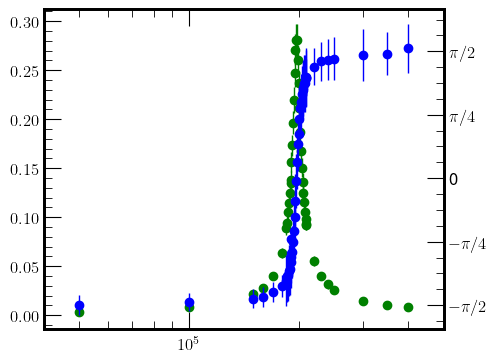

In [7]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f, Tf, yerr=sTf , fmt='go')
axA.semilogx()
axF = axA.twinx()

axF.set_yticks((-np.pi/2,-np.pi/4,0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$','0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi, xerr=sphi , fmt='bo')

axA.set_xlim(min(f)-1e4,max(f)+10**5)

plt.show()

In [8]:
inizio = 1.8e5
fine = 2.3e5

[1.16750646e+01 1.97313314e+05 2.81302555e-01] [[2.14142985e-01 1.57787824e+00 2.99157433e-03]
 [1.57787824e+00 1.57594229e+04 3.09866859e-03]
 [2.99157433e-03 3.09866859e-03 5.27210240e-05]]
0.0733264044100333


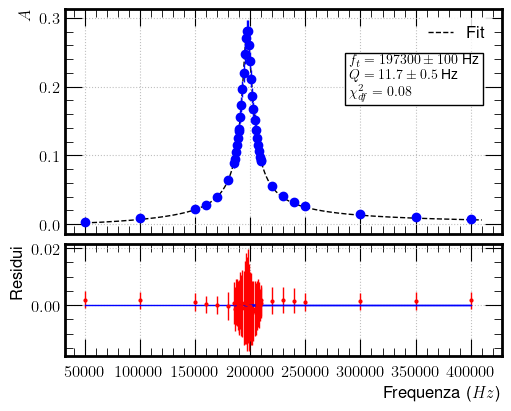

In [9]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_Tf_R, f[f>inizio][f<fine], Tf[f>inizio][f<fine], p0=[36, 196850, 0.3], method='lm' ,sigma=sTf[f>inizio][f<fine], absolute_sigma=True)
print(valtr, covtr)

resTr = Tf - fit_Tf_R(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))
qvalore.append(valtr[0])
sqvalore.append(np.sqrt(covtr[0,0]))
covfq.append(covtr[0,1])


# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_Tf_R(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2Tf/(len(f)-2))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

[1.92838551e+01 1.96790433e+05] [[4.63769628e+00 9.34657600e+01]
 [9.34657600e+01 2.10927334e+05]]
6.671530008604637e-05


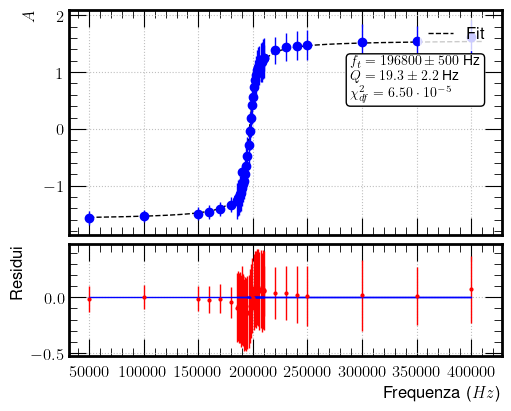

In [10]:
# Fit della funzione di trasferimento non lineare
valphi, covphi = curve_fit(fit_phi_R, f[f>inizio][f<fine], phi[f>inizio][f<fine], p0=[36, 196850], method='lm' ,sigma=sphi[f>inizio][f<fine], absolute_sigma=True)
print(valphi, covphi)

resphi = phi - fit_phi_R(f, *valphi)
chi2phi = np.sum((resTr/sphi)**2)
print(chi2phi/(len(f)-2))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(valphi[1])
sfrequenze.append(np.sqrt(covphi[1,1]))
qvalore.append(valphi[0])
sqvalore.append(np.sqrt(covphi[0,0]))
covfq.append(covphi[0,1])

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_R(x_fit, *valphi), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, phi, yerr=sphi , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valphi[1],-2), round(np.sqrt(covphi[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valphi[0], np.sqrt(covphi[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phi/(len(f)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resphi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

In [11]:
# Importazione dei dati per fit globale
dataC = pd.read_csv('Dati C.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fC = dataC["f"]
phiC = 2e-9 * np.pi * dataC["f"] * dataC["dT"] # in rapporto a 90°
sphiC = 2e-6 * np.pi * dataC["f"] * np.sqrt(dataC["sT"]/(25*12**0.5))

sVin = np.sqrt((0.03*dataC["Ach1"]/(24**0.5))**2+(dataC["Sch1"]/(25*24**0.5))) # Assumo triangolare

TfC = dataC["Ach2"]/dataC["Ach1"]
sTfC = np.sqrt((0.03*dataC["Ach2"]/(12**0.5))**2+(dataC["Sch2"]/(25*12**0.5)) + (dataC["Ach2"]/dataC["Ach1"] * sVin)**2)/dataC["Ach1"] # Assumo uniforme

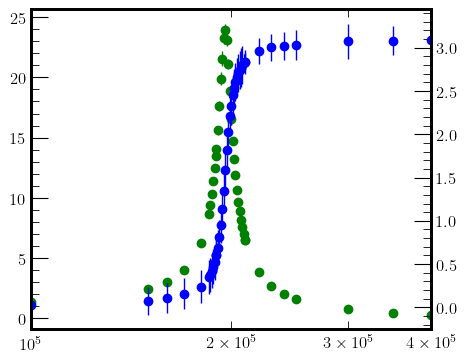

In [12]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(fC, TfC, yerr=sTfC , fmt='go')
axA.semilogx()
axF = axA.twinx()

axF.errorbar(fC, phiC,  yerr= sphiC, fmt='bo')

axA.set_xlim(min(fC),max(fC))

plt.show()

[2.34795342e+01 1.95944858e+05 1.01369819e+00] [[ 1.19670499e-01  5.56277901e-01 -1.60304844e-03]
 [ 5.56277901e-01  2.02447810e+03 -5.62887438e-02]
 [-1.60304844e-03 -5.62887438e-02  3.87505155e-05]]
0.1315481997407655


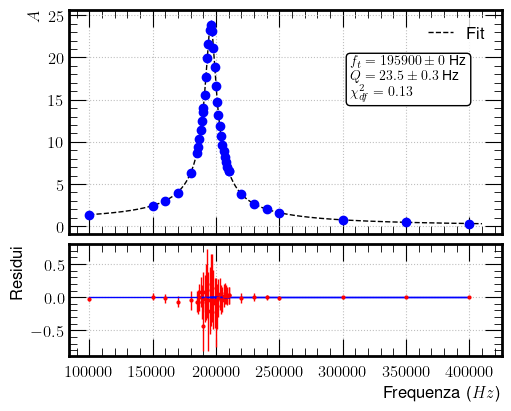

In [13]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_Tf_C, fC[f>inizio][f<fine], TfC[f>inizio][f<fine], p0=[11.6, 197300, 1], method='lm' ,sigma=sTfC[f>inizio][f<fine], absolute_sigma=True)
print(valtr, covtr)

resTr = TfC - fit_Tf_C(fC, *valtr)
chi2TfC = np.sum((resTr/sTfC)**2)
print(chi2TfC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))
qvalore.append(valtr[0])
sqvalore.append(np.sqrt(covtr[0,0]))
covfq.append(covtr[0,1])


# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_Tf_C(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, TfC, yerr=sTfC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2TfC/(len(fC)-1))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)

ax[1].errorbar(fC,resTr,yerr=sTfC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

[2.36277969e+01 1.95905153e+05 1.56599316e+00] [[ 5.71139468e+00 -2.22868263e+02 -3.89573677e-02]
 [-2.22868263e+02  2.84409425e+05  1.98465954e+01]
 [-3.89573677e-02  1.98465954e+01  2.64554567e-03]]
0.0027423092750699673


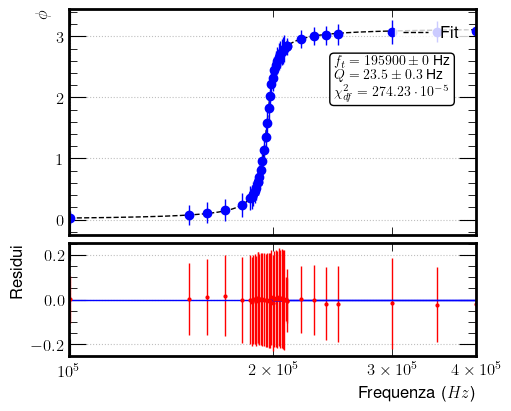

In [14]:
# Fit della funzione di trasferimento non lineare
valphiC, covphiC = curve_fit(fit_phi_c, fC[f>inizio][f<fine], phiC[f>inizio][f<fine], p0=[11, 196850, np.pi/2], method='lm' ,sigma=sphiC[f>inizio][f<fine], absolute_sigma=True)
print(valphiC, covphiC)

resphiC = phiC - fit_phi_c(fC, *valphiC)
chi2phiC = np.sum((resphiC/sphiC)**2)
print(chi2phiC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

# frequenze.append(valphiC[1])
# sfrequenze.append(np.sqrt(covphiC[1,1]))

# qvalore.append(valphiC[0])
# sqvalore.append(np.sqrt(covphiC[0,0]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_c(x_fit, *valphiC), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, phiC, yerr=sphiC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$\phi$')
ax[0].semilogx()
ax[0].set_xlim(min(fC)-10, max(fC)+10)

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phiC/(len(fC)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(fC,resphiC,yerr=sphiC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

[2.35806052e+01 1.95884214e+05 1.56320153e+00] [[ 4.82384983e+00 -1.02030538e+02 -1.45547303e-02]
 [-1.02030538e+02  1.82404450e+05  9.26406694e+00]
 [-1.45547303e-02  9.26406694e+00  1.24945922e-03]]
0.0025476320156400754


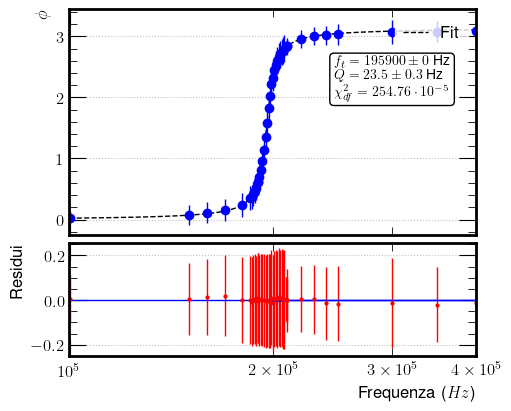

In [15]:
# Fit della funzione di trasferimento non lineare
valphiC, covphiC = curve_fit(fit_phi_c, fC, phiC, p0=[11, 196850, np.pi/2], method='lm' ,sigma=sphiC, absolute_sigma=True)
print(valphiC, covphiC)

resphiC = phiC - fit_phi_c(fC, *valphiC)
chi2phiC = np.sum((resphiC/sphiC)**2)
print(chi2phiC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

frequenze.append(valphiC[1])
sfrequenze.append(np.sqrt(covphiC[1,1]))
qvalore.append(valphiC[0])
sqvalore.append(np.sqrt(covphiC[0,0]))
covfq.append(covphiC[0,1])

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_c(x_fit, *valphiC), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, phiC, yerr=sphiC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$\phi$')
ax[0].semilogx()
ax[0].set_xlim(min(fC)-10, max(fC)+10)

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phiC/(len(fC)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(fC,resphiC,yerr=sphiC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

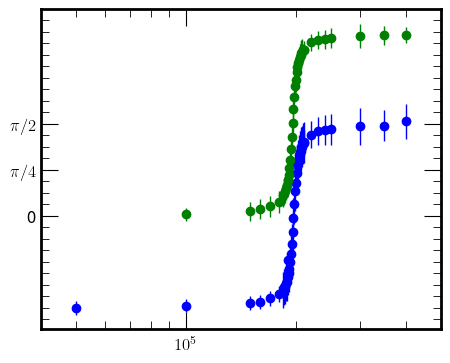

In [16]:
# Plot dei dati importati
fig, axF = plt.subplots(1,1, figsize=(5,4))
axF.semilogx()

axF.set_yticks((0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels(('0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi , fmt='bo')
axF.errorbar(fC, phiC,  yerr= sphiC, fmt='go')

axF.set_xlim(min(f)-1e4,max(f)+10**5)

plt.show()

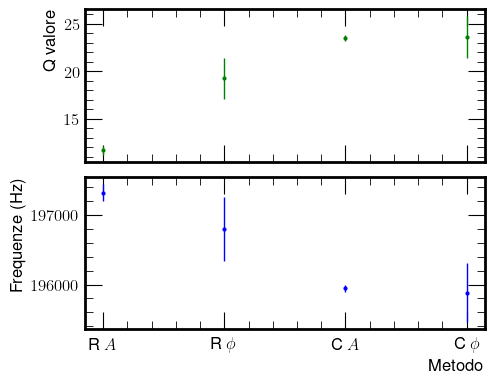

In [17]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], qvalore,  yerr= sqvalore , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], frequenze,  yerr= sfrequenze , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"R $\phi$", r"C $A$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("Q valore")
ax[1].set_ylabel("Frequenze (Hz)")

plt.show()

In [18]:
# Stime di R e L con C fisso
Cfisso = 1.09*10**-9
sCfisso = 0.08*10**-9

f = np.array(frequenze)
sf = np.array(sfrequenze)
q = np.array(qvalore)
sq = np.array(sqvalore)
cov = np.array(covfq)

L = 1/(f**2*Cfisso*4*np.pi**2)
sL = L * np.sqrt((sf/f)**2+(sCfisso/Cfisso)**2)

R = 1/(f*q*Cfisso*2*np.pi)
sR = R * np.sqrt((sf/f)**2 + (sCfisso/Cfisso)**2 + (sq/q)**2 + 2 * cov/(q*f))

for i in range(4):
    print("L: ", L[i], "+/-", sL[i])
for i in range(4):
    print("R: ", R[i], "+/-", sR[i])

L:  0.0005968991795041378 +/- 4.3810760080801523e-05
L:  0.0006000753704434053 +/- 4.406448914226322e-05
L:  0.0006052656461746796 +/- 4.4423384110381934e-05
L:  0.0006056404730139414 +/- 4.447028622233748e-05
R:  63.383752642065716 +/- 5.28772455108077
R:  38.47652058826734 +/- 5.149653516153855
R:  31.73732255689231 +/- 2.375877392649633
R:  31.61107380800525 +/- 3.743292466979266


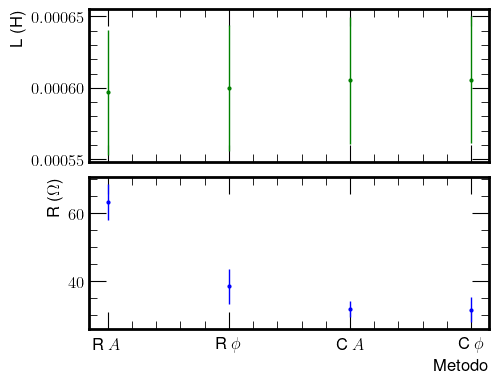

In [19]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], L,  yerr= sL , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], R,  yerr= sR , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"R $\phi$", r"C $A$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("L (H)")
ax[1].set_ylabel(r"R ($\Omega$)")

plt.show()

In [20]:
# Stime di L e C con R fissato
Rfisso = 20.50
sRfisso = 0.07

L2 = q*Rfisso/(f*2*np.pi)
sL2 = L2 * np.sqrt((sf/f)**2+(sq/q)**2+2*cov/(f*q)+(sRfisso/Rfisso)**2)

C = 1/(q*Rfisso*f*2*np.pi)
sC = C * np.sqrt((sf/f)**2+(sq/q)**2+2*cov/(f*q)+(sRfisso/Rfisso)**2)

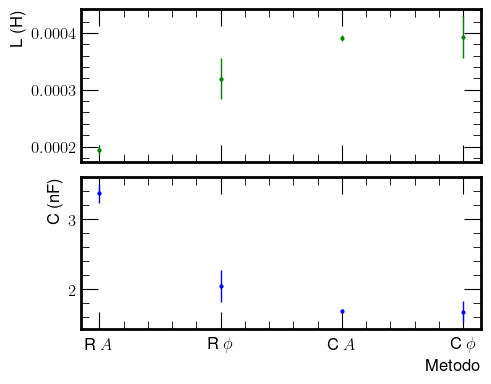

In [21]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], L2,  yerr= sL2 , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], C*10**9,  yerr= sC*10**9 , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"R $\phi$", r"C $A$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("L (H)")
ax[1].set_ylabel(r"C (nF)")

plt.show()

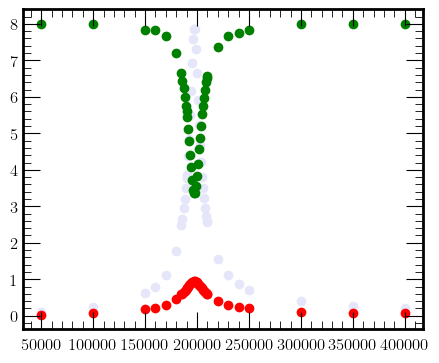

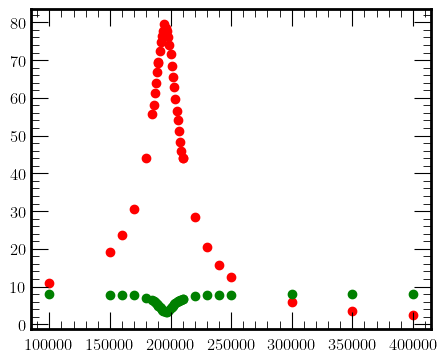

In [29]:
fig, axA = plt.subplots(1,1, figsize=(5,4))
V2 = np.array(data["Ach2"])
V1 = np.array(data["Ach1"])

axA.scatter(f, Tf*28, c = "lavender")
axA.scatter(f, V2, color = "red")
axA.scatter(f, V1, color = "green")
plt.show()

fig, axA = plt.subplots(1,1, figsize=(5,4))

axA.scatter(fC, dataC["Ach2"], color = "red")
axA.scatter(fC, dataC["Ach1"], color = "green")


# axA.set_xlim(min(fC),max(fC))

plt.show()

In [73]:
piniz = 1.93e5
pfin = 2.015e5
Vinm = 8 #V

rG = 48.4 # Ohm
parvalue, covpar = curve_fit(parabola, f[f>piniz][f<pfin], V1[f>piniz][f[f>piniz]<pfin], method='lm' ,sigma=sTf[f>piniz][f[f>piniz]<pfin], absolute_sigma=True)

fmax = -parvalue[1]/(2*parvalue[0])

print(parabola(fmax, *parvalue), fmax)

print(parvalue, "\n" ,covpar)

rcircuito = Vinm * rG / (Vinm - parabola(fmax, *parvalue1))
print(rcircuito)

3.3617818536845334 197358.8482013846
[ 6.27780181e-08 -2.47795947e-02  2.44859791e+03] 
 [[ 1.19433143e-18 -4.71785857e-13  4.65839737e-08]
 [-4.71785857e-13  1.86369411e-07 -1.84024618e-02]
 [ 4.65839737e-08 -1.84024618e-02  1.81713386e+03]]
54.5695779513489


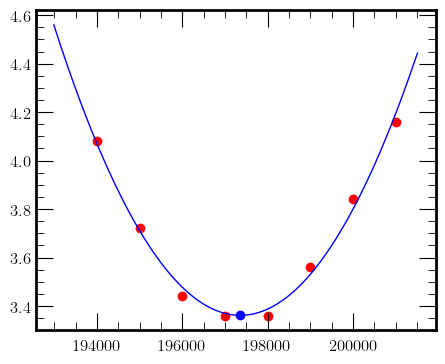

In [72]:
fig, axA = plt.subplots(1,1, figsize=(5,4))
V2 = np.array(data["Ach2"])
xfit = np.linspace(piniz-10,pfin+10,500)
axA.scatter(f[f>piniz][f<pfin], V1[f>piniz][f[f>piniz]<pfin], color = "red")
axA.plot(xfit, parabola(xfit,*parvalue))
axA.scatter(fmax, parabola(fmax, *parvalue))
plt.show()
